In [1]:
pip install segmentation-models-pytorch albumentations opencv-python tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

In [12]:
import os
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

def prepare_and_train_model(
    data_root,
    image_size=(256, 256),
    model_name="UnetPlusPlus",
    encoder="resnet34",
    encoder_weights="imagenet",
    batch_size=8,
    epochs=25,
    lr=1e-4,
    save_path="unetplusplus_model.pth",
    seed=42
):
    random.seed(seed)
    torch.manual_seed(seed)

    # Dossiers
    image_dir = os.path.join(data_root, "images")
    mask_dir = os.path.join(data_root, "masks")
    all_images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    # Split
    train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=seed)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=1/3, random_state=seed)

    class MedicalDataset(Dataset):
        def __init__(self, files, image_dir, mask_dir, transform=None):
            self.files = files
            self.image_dir = image_dir
            self.mask_dir = mask_dir
            self.transform = transform

        def __len__(self):
            return len(self.files)

        def __getitem__(self, idx):
            img_name = self.files[idx]
            img_path = os.path.join(self.image_dir, img_name)
            base_name, ext = os.path.splitext(img_name)
            mask_name = base_name + "_mask" + ext
            mask_path = os.path.join(self.mask_dir, mask_name)
            if not os.path.exists(mask_path):
                mask_name = base_name + ext
            mask_path = os.path.join(self.mask_dir, mask_name)

            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = np.stack([image] * 3, axis=-1)  # 1 canal → 3 canaux

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype(np.float32)  # Binarisation

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented["image"]
                mask = augmented["mask"]

            return image, mask.unsqueeze(0).float()

    # Augmentations
    transform = A.Compose([
        A.Resize(*image_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

    train_ds = MedicalDataset(train_imgs, image_dir, mask_dir, transform)
    val_ds = MedicalDataset(val_imgs, image_dir, mask_dir, transform)
    test_ds = MedicalDataset(test_imgs, image_dir, mask_dir, transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Modèle
    model_class = getattr(smp, model_name)
    model = model_class(
        encoder_name=encoder,
        encoder_weights=encoder_weights,
        in_channels=3,
        classes=1,
        activation=None
    )

    if torch.cuda.device_count() > 1:
        print(f"🧠 Utilisation de {torch.cuda.device_count()} GPU")
        model = torch.nn.DataParallel(model)

    model = model.to(DEVICE)

    # Fonctions de perte
    dice_loss = smp.losses.DiceLoss(mode='binary')
    bce_loss = smp.losses.SoftBCEWithLogitsLoss()

    def combined_loss(preds, targets):
        return dice_loss(torch.sigmoid(preds), targets) + bce_loss(preds, targets)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Entraînement
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}")

        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            preds = model(images)
            loss = combined_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"✅ Epoch {epoch+1} — Train Loss: {total_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                preds = model(images)
                loss = combined_loss(preds, masks)
                val_loss += loss.item()
        print(f"🔍 Epoch {epoch+1} — Val Loss: {val_loss/len(val_loader):.4f}")

    torch.save(model.state_dict(), save_path)
    print(f"📦 Modèle sauvegardé : {save_path}")

    return model, test_loader


In [13]:
model, test_loader = prepare_and_train_model(
    data_root="/kaggle/input/seg-tumor/data",  # chemin vers /images et /masks
    image_size=(512, 512),
    model_name="UnetPlusPlus",
    encoder="resnet34",
    encoder_weights="imagenet",
    batch_size=8,
    epochs=25,
    lr=1e-4,
    save_path="unetplusplus_model.pth",
    seed=42
)

🧠 Utilisation de 2 GPU


[Train] Epoch 1/25: 100%|██████████| 114/114 [01:19<00:00,  1.44it/s, loss=1.25]


✅ Epoch 1 — Train Loss: 1.1843
🔍 Epoch 1 — Val Loss: 1.0815


[Train] Epoch 2/25: 100%|██████████| 114/114 [01:16<00:00,  1.50it/s, loss=1.17] 


✅ Epoch 2 — Train Loss: 1.0623
🔍 Epoch 2 — Val Loss: 1.0248


[Train] Epoch 3/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.984]


✅ Epoch 3 — Train Loss: 1.0202
🔍 Epoch 3 — Val Loss: 0.9981


[Train] Epoch 4/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.994]


✅ Epoch 4 — Train Loss: 0.9976
🔍 Epoch 4 — Val Loss: 0.9871


[Train] Epoch 5/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.839]


✅ Epoch 5 — Train Loss: 0.9825
🔍 Epoch 5 — Val Loss: 0.9775


[Train] Epoch 6/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=1.08] 


✅ Epoch 6 — Train Loss: 0.9769
🔍 Epoch 6 — Val Loss: 0.9751


[Train] Epoch 7/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.996]


✅ Epoch 7 — Train Loss: 0.9691
🔍 Epoch 7 — Val Loss: 0.9701


[Train] Epoch 8/25: 100%|██████████| 114/114 [01:16<00:00,  1.50it/s, loss=0.927]


✅ Epoch 8 — Train Loss: 0.9631
🔍 Epoch 8 — Val Loss: 0.9608


[Train] Epoch 9/25: 100%|██████████| 114/114 [01:16<00:00,  1.49it/s, loss=1.29] 


✅ Epoch 9 — Train Loss: 0.9590
🔍 Epoch 9 — Val Loss: 0.9543


[Train] Epoch 10/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.999]


✅ Epoch 10 — Train Loss: 0.9549
🔍 Epoch 10 — Val Loss: 0.9561


[Train] Epoch 11/25: 100%|██████████| 114/114 [01:16<00:00,  1.50it/s, loss=0.85] 


✅ Epoch 11 — Train Loss: 0.9523
🔍 Epoch 11 — Val Loss: 0.9575


[Train] Epoch 12/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.987]


✅ Epoch 12 — Train Loss: 0.9443
🔍 Epoch 12 — Val Loss: 0.9609


[Train] Epoch 13/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.735]


✅ Epoch 13 — Train Loss: 0.9441
🔍 Epoch 13 — Val Loss: 0.9528


[Train] Epoch 14/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=1.06] 


✅ Epoch 14 — Train Loss: 0.9426
🔍 Epoch 14 — Val Loss: 0.9460


[Train] Epoch 15/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.819]


✅ Epoch 15 — Train Loss: 0.9327
🔍 Epoch 15 — Val Loss: 0.9514


[Train] Epoch 16/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.787]


✅ Epoch 16 — Train Loss: 0.9362
🔍 Epoch 16 — Val Loss: 0.9540


[Train] Epoch 17/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.951]


✅ Epoch 17 — Train Loss: 0.9366
🔍 Epoch 17 — Val Loss: 0.9506


[Train] Epoch 18/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.934]


✅ Epoch 18 — Train Loss: 0.9328
🔍 Epoch 18 — Val Loss: 0.9595


[Train] Epoch 19/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.903]


✅ Epoch 19 — Train Loss: 0.9344
🔍 Epoch 19 — Val Loss: 0.9641


[Train] Epoch 20/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.999]


✅ Epoch 20 — Train Loss: 0.9299
🔍 Epoch 20 — Val Loss: 0.9516


[Train] Epoch 21/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=1]    


✅ Epoch 21 — Train Loss: 0.9288
🔍 Epoch 21 — Val Loss: 0.9560


[Train] Epoch 22/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.974]


✅ Epoch 22 — Train Loss: 0.9247
🔍 Epoch 22 — Val Loss: 0.9537


[Train] Epoch 23/25: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.874]


✅ Epoch 23 — Train Loss: 0.9239
🔍 Epoch 23 — Val Loss: 0.9559


[Train] Epoch 24/25: 100%|██████████| 114/114 [01:16<00:00,  1.50it/s, loss=0.891]


✅ Epoch 24 — Train Loss: 0.9229
🔍 Epoch 24 — Val Loss: 0.9622


[Train] Epoch 25/25: 100%|██████████| 114/114 [01:15<00:00,  1.50it/s, loss=0.988]


✅ Epoch 25 — Train Loss: 0.9255
🔍 Epoch 25 — Val Loss: 0.9538
📦 Modèle sauvegardé : unetplusplus_model.pth


In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from tqdm import tqdm

def evaluate_model_metrics(model, dataloader, device=None, threshold=0.5):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Évaluation"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = torch.sigmoid(model(images))
            preds = (outputs > threshold).float()

            y_true.extend(masks.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())

    y_true = np.array(y_true).astype(np.uint8)
    y_pred = np.array(y_pred).astype(np.uint8)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"Accuracy  : {accuracy:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")

    return accuracy, f1, precision, recall


In [16]:
accuracy, f1, precision, recall = evaluate_model_metrics(model, test_loader)


Évaluation: 100%|██████████| 130/130 [00:14<00:00,  8.98it/s]


Accuracy  : 0.9754
F1 Score  : 0.7828
Precision : 0.8079
Recall    : 0.7592


In [17]:
import matplotlib.pyplot as plt

def predict_and_show(model, image_path, mask_path, image_size=(512, 512), device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charger image et masque
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, image_size)

    # Dupliquer l’image grayscale en 3 canaux
    image_3ch = np.stack([image] * 3, axis=-1)

    # Prétraitement
    transform = A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])
    augmented = transform(image=image_3ch, mask=mask)
    input_tensor = augmented["image"].unsqueeze(0).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

    # Affichage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Masque réel")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Masque prédit")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


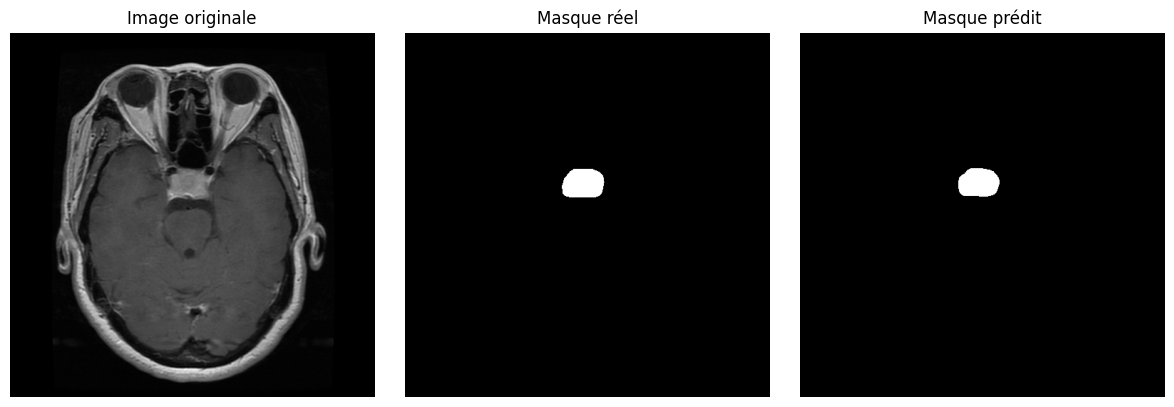

In [19]:
predict_and_show(
    model=model,
    image_path="/kaggle/input/seg-tumor/data/images/1008.png",
    mask_path="/kaggle/input/seg-tumor/data/masks/1008.png",
    image_size=(512, 512)
)
